# Implementation of DLRM (10%/Random Noise/APFL) 

## Imports

In [18]:
SYFT_VERSION = ">=0.8.2.b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# %pip install {package_string} -q

import tensorflow as tf
from tensorflow.keras.metrics import AUC
# syft absolute
import syft as sy

sy.requires(SYFT_VERSION)

import pandas as pd
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np


✅ The installed version of syft==0.8.4 matches the requirement >=0.8.2b0 and the requirement <0.9


## Load and preprocess the data

In [19]:
# Set the seed for reproducibility
np.random.seed(42)

# Total number of rows in the dataset (excluding the header)
total_rows = 1364729

# Number of rows to load - 10% of the total rows
rows_to_load = total_rows // 10

# Generate a sorted list of random indices to skip, aiming to load about 10% of the dataset
skip_rows = np.sort(np.random.choice(np.arange(1, total_rows + 1), size=(total_rows - rows_to_load), replace=False))

# Define the column names
columns = ['label', *(f'I{i}' for i in range(1, 14)), *(f'C{i}' for i in range(1, 27))]

# Load the dataset, skipping the selected rows
df = pd.read_csv('/Users/alex/Thesis/New Dataset/train.txt', sep='\t', names=columns, skiprows=skip_rows).fillna(0)

# Check the loaded data
print(f"Loaded rows: {len(df)}")

Loaded rows: 136473


In [20]:
# Preprocess Dense Features
dense_cols = [c for c in columns if 'I' in c]
df[dense_cols] = preprocessing.StandardScaler().fit_transform(df[dense_cols])
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.134357,-0.264834,-0.037551,-0.665336,-0.251022,-0.285512,0.022657,-0.416195,0.391602,...,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,0,3a171ecb,c5c50484,e8b83407,9727dd16
1,1,-0.289223,-0.057509,-0.047134,1.216693,-0.207498,-0.015080,-0.181215,0.173649,0.627000,...,e5ba7672,df00d249,0,0,f520f961,0,32c7478e,27b60b01,0,0
2,0,-0.289223,-0.267527,-0.043940,0.840287,-0.162964,0.024984,-0.218283,0.284245,-0.045566,...,e5ba7672,2a93f7c8,0,0,5dc9a057,0,32c7478e,90b6276f,0,0
3,0,-0.289223,-0.216369,-0.024773,-0.288930,-0.057373,4.218350,-0.199749,-0.453060,1.261135,...,8efede7f,5aed7436,21ddcdc9,a458ea53,3c1a8dd8,0,3a171ecb,3fdb382b,b9266ff0,49d68486
4,0,-0.289223,-0.219061,-0.015190,0.338413,-0.138342,-0.151965,-0.218283,-0.047543,-0.204100,...,07c540c4,0f2f9850,5fd56cf9,b1252a9d,96725293,0,32c7478e,2702453c,8b8de563,303cea07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136468,0,0.175374,-0.262142,-0.008801,1.216693,-0.269388,-0.232093,-0.051478,0.063053,1.208290,...,3486227d,ae09efbe,0,0,80d4b4fb,c9d4222a,423fab69,5ddc2c4c,0,0
136469,0,-0.134357,-0.259449,0.320225,-0.414399,-0.270190,-0.081853,-0.236817,0.616032,-0.386654,...,e5ba7672,6fc84bfb,0,0,5155d8a3,0,423fab69,ded4aac9,0,0
136470,0,-0.134357,-0.270219,-0.053523,-0.665336,-0.252656,-0.298867,-0.236817,-0.489925,-0.477931,...,d4bb7bd8,ab194a92,0,0,21c9516a,0,32c7478e,b34f3128,0,0
136471,0,-0.134357,-0.235216,-0.034357,0.087476,-0.270220,-0.262141,-0.236817,-0.231869,-0.444302,...,d4bb7bd8,e4ca448c,0,0,f8af07d5,ad3062eb,32c7478e,9117a34a,0,0


In [21]:
# Preprocess Categorical Features
cat_cols = [c for c in columns if 'C' in c]
mappings = {
    col: dict(zip(values, range(len(values))))
    for col, values in map(lambda col: (col, df[col].unique()), cat_cols)
}
for col, mapping in mappings.items():
    df[col] = df[col].map(mapping.get)
df

,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,-0.134357,-0.264834,-0.037551,-0.665336,-0.251022,-0.285512,0.022657,-0.416195,0.391602,...,0,0,0,0,0,0,0,0,0,0
1,1,-0.289223,-0.057509,-0.047134,1.216693,-0.207498,-0.015080,-0.181215,0.173649,0.627000,...,0,1,1,1,1,0,1,1,1,1
2,0,-0.289223,-0.267527,-0.043940,0.840287,-0.162964,0.024984,-0.218283,0.284245,-0.045566,...,0,2,1,1,2,0,1,2,1,1
3,0,-0.289223,-0.216369,-0.024773,-0.288930,-0.057373,4.218350,-0.199749,-0.453060,1.261135,...,1,3,0,2,3,0,0,3,2,2
4,0,-0.289223,-0.219061,-0.015190,0.338413,-0.138342,-0.151965,-0.218283,-0.047543,-0.204100,...,2,4,2,0,4,0,1,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136468,0,0.175374,-0.262142,-0.008801,1.216693,-0.269388,-0.232093,-0.051478,0.063053,1.208290,...,8,91,1,1,7735,2,3,81,1,1
136469,0,-0.134357,-0.259449,0.320225,-0.414399,-0.270190,-0.081853,-0.236817,0.616032,-0.386654,...,0,148,1,1,1521,0,3,119,1,1
136470,0,-0.134357,-0.270219,-0.053523,-0.665336,-0.252656,-0.298867,-0.236817,-0.489925,-0.477931,...,6,475,1,1,70,0,1,16,1,1
136471,0,-0.134357,-0.235216,-0.034357,0.087476,-0.270220,-0.262141,-0.236817,-0.231869,-0.444302,...,6,280,1,1,46292,1,1,68,1,1


In [22]:
label_counts = df.groupby('label')['I1'].count()
print(f'Baseline: {max(label_counts.values) / sum(label_counts.values) * 100}%')

Baseline: 74.8177295142629%


In [23]:
# Select halfway point for the split
split_point = len(df) // 2

# Define the noise level
noise_level = 0.5  # Adjust this based on your dataset's scale

# Add random noise only to the first half for integer features I1 to I13
# Generating noise with the same shape as the target DataFrame slice
noise = np.random.normal(0, noise_level, df.loc[:split_point, 'I1':'I13'].shape)
df.loc[:split_point, 'I1':'I13'] += noise

# Now split the DataFrame into two parts: one with added noise and one without any modifications
df1 = df.iloc[:split_point].reset_index(drop=True)
df2 = df.iloc[split_point:].reset_index(drop=True)

# Verifying the manipulation
print(f"Total records: {len(df)}")
print(f"df1 records: {len(df1)} - with added noise")
print(f"df2 records: {len(df2)} - without added noise")

Total records: 136473
df1 records: 68236 - with added noise
df2 records: 68237 - without added noise


In [24]:
dense_cols = [c for c in df.columns if 'I' in c]
cat_cols = [c for c in df.columns if 'C' in c]
fixed_embedding_size = 455000
emb_counts = [len(df[c].unique()) for c in cat_cols]

## Data Owner 1

In [25]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [26]:
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()

    for units in arch[:-1]:
        mlp.add(tf.keras.layers.Dense(units, activation=activation))

    mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))

    return mlp


class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interaction=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)

        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)

        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2)

        if not self.self_interaction:
            mask = mask - tf.linalg.band_part(ones, 0, 0)
            out_dim = int(len(inputs) * (len(inputs) - 1) / 2)

        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions


class DLRM(tf.keras.Model):
    def __init__(
            self,
            embedding_sizes,
            embedding_dim,
            arch_bot,
            arch_top,
            self_interaction,
    ):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, input):
        input_dense, input_cat = input
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

In [27]:
model = DLRM(
    embedding_sizes=emb_counts,
    embedding_dim=2,
    arch_bot=[8, 2],
    arch_top=[128, 64, 2],
    self_interaction=False
)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]  
)

In [28]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 3s 4ms/step - loss: 0.6096 - accuracy: 0.7460 - auc: 0.7402 - val_loss: 0.5580 - val_accuracy: 0.7472 - val_auc: 0.7843
Epoch 2/5
427/427 [==============================] - 2s 4ms/step - loss: 0.5408 - accuracy: 0.7469 - auc: 0.8046 - val_loss: 0.5210 - val_accuracy: 0.7508 - val_auc: 0.8240
Epoch 3/5
427/427 [==============================] - 2s 4ms/step - loss: 0.5010 - accuracy: 0.7594 - auc: 0.8368 - val_loss: 0.4979 - val_accuracy: 0.7647 - val_auc: 0.8383
Epoch 4/5
427/427 [==============================] - 2s 4ms/step - loss: 0.4601 - accuracy: 0.7846 - auc: 0.8650 - val_loss: 0.4883 - val_accuracy: 0.7713 - val_auc: 0.8468
Epoch 5/5
427/427 [==============================] - 2s 4ms/step - loss: 0.4145 - accuracy: 0.8123 - auc: 0.8928 - val_loss: 0.5046 - val_accuracy: 0.7578 - val_auc: 0.8381


In [29]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple                  16824  

In [30]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 0s 1ms/step - loss: 0.5419 - accuracy: 0.7441 - auc: 0.8175
Loss: 0.5418701767921448, Accuracy: 0.7441157698631287, AUC: 0.8175066709518433


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.609647,0.745970,0.740188,0.558031,0.747160,0.784345
1,0.540770,0.746941,0.804601,0.521013,0.750824,0.823975
2,0.501013,0.759361,0.836824,0.497918,0.764749,0.838326
3,0.460059,0.784605,0.864961,0.488281,0.771345,0.846823
4,0.414465,0.812303,0.892783,0.504641,0.757787,0.838071


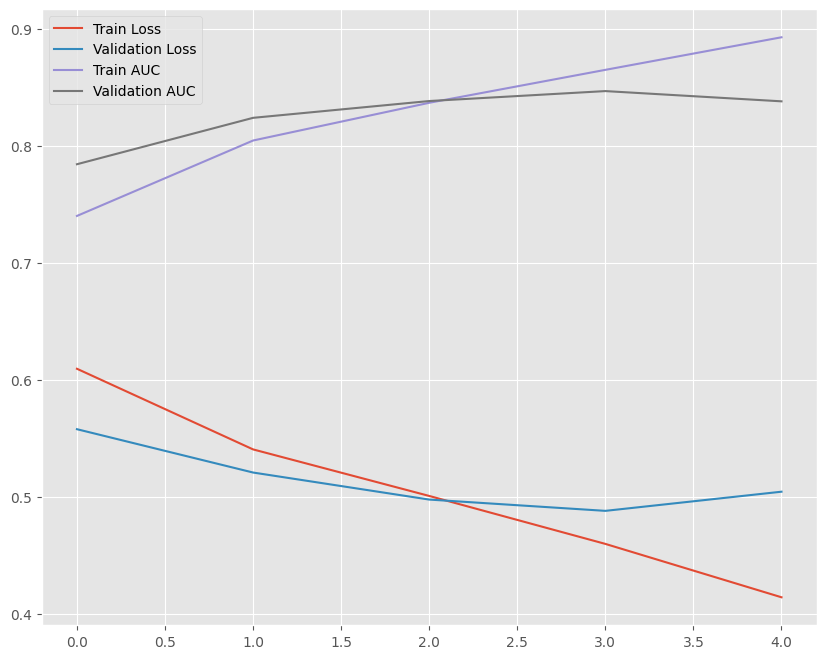

Validation AUC: 0.8442


In [31]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = model.metrics_names.index('auc')
auc_score_baseline1 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline1:.4f}")

In [32]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_1 = {v.name: v.numpy() for v in model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_1 = add_noise_to_weights(model_weights_dict_1, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [33]:
node = sy.orchestra.launch(name="test-domain-1", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-1 server on 0.0.0.0:51573


kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


Waiting for server to start..

INFO:     Started server process [2515]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:51573 (Press CTRL+C to quit)


.
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/7bca415d13ed4ec881f0d0aede098dbb.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=4ad74ae7ddfd449b961476802a829067 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:53232 - "GET /api/v2/metadata HTTP/1.1" 200 OK
 Done.


Login to the Domain

In [34]:
domain_client = node.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:53234 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:53234 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-1: High-side Domain> as GUEST
INFO:     127.0.0.1:53234 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:53234 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:53236 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-1: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [35]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_1)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> a363c020306147fdb4310a540e0b1c84


In [36]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:53238 - "POST /api/v2/api_call HTTP/1.1" 200 OK
a363c020306147fdb4310a540e0b1c84


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [37]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:53240 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53234 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [38]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/58c30a31a64b4800bde7f81100054b94.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=05732ca1a1cc4fd6b38f3c844dff89fc in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_1823: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:53247 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53249 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_1823
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [39]:
request = domain_client.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:53252 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53234 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:53254 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53256 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53258 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53260 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53262 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53264 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53266 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [40]:
request.approve()

INFO:     127.0.0.1:53234 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:53268 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53270 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53272 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53274 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53276 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53278 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53280 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-1
INFO:     127.0.0.1:53282 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request feec849f44dc48188aab5085423a0d9a changes applied

In [41]:
domain_client._api = None
_ = domain_client.api

INFO:     127.0.0.1:53234 - "GET /api/v2/api?verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [42]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/095cbdaab47248f8ac98b6d65bff2829.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=62bceca254d84cc6a160c976be99e84c in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_8704: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:53288 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53290 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_8704
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [43]:
if node.node_type.value == "python":
    node.land()

## Data Owner 2

In [44]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [45]:
def MLP(arch, activation='relu', out_activation=None):
    mlp = tf.keras.Sequential()

    for units in arch[:-1]:
        mlp.add(tf.keras.layers.Dense(units, activation=activation))

    mlp.add(tf.keras.layers.Dense(arch[-1], activation=out_activation))

    return mlp


class SecondOrderFeatureInteraction(tf.keras.layers.Layer):
    def __init__(self, self_interaction=False):
        super(SecondOrderFeatureInteraction, self).__init__()
        self.self_interaction = self_interaction

    def call(self, inputs):
        batch_size = tf.shape(inputs[0])[0]
        concat_features = tf.stack(inputs, axis=1)

        dot_products = tf.matmul(concat_features, concat_features, transpose_b=True)

        ones = tf.ones_like(dot_products)
        mask = tf.linalg.band_part(ones, 0, -1)
        out_dim = int(len(inputs) * (len(inputs) + 1) / 2)

        if not self.self_interaction:
            mask = mask - tf.linalg.band_part(ones, 0, 0)
            out_dim = int(len(inputs) * (len(inputs) - 1) / 2)

        flat_interactions = tf.reshape(tf.boolean_mask(dot_products, mask), (batch_size, out_dim))
        return flat_interactions


class DLRM(tf.keras.Model):
    def __init__(
            self,
            embedding_sizes,
            embedding_dim,
            arch_bot,
            arch_top,
            self_interaction,
    ):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, input):
        input_dense, input_cat = input
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

In [46]:
model = DLRM(
    embedding_sizes=emb_counts,
    embedding_dim=2,
    arch_bot=[8, 2],
    arch_top=[128, 64, 2],
    self_interaction=False
)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]  
)

In [47]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 3s 5ms/step - loss: 0.6047 - accuracy: 0.7439 - auc: 0.7573 - val_loss: 0.5412 - val_accuracy: 0.7563 - val_auc: 0.8066
Epoch 2/5
427/427 [==============================] - 2s 5ms/step - loss: 0.5345 - accuracy: 0.7495 - auc: 0.8188 - val_loss: 0.5054 - val_accuracy: 0.7563 - val_auc: 0.8378
Epoch 3/5
427/427 [==============================] - 2s 5ms/step - loss: 0.4922 - accuracy: 0.7649 - auc: 0.8439 - val_loss: 0.4895 - val_accuracy: 0.7779 - val_auc: 0.8453
Epoch 4/5
427/427 [==============================] - 2s 6ms/step - loss: 0.4557 - accuracy: 0.7875 - auc: 0.8683 - val_loss: 0.4742 - val_accuracy: 0.7798 - val_auc: 0.8571
Epoch 5/5
427/427 [==============================] - 3s 6ms/step - loss: 0.4163 - accuracy: 0.8112 - auc: 0.8920 - val_loss: 0.4889 - val_accuracy: 0.7710 - val_auc: 0.8497


In [48]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple                  16824  

In [49]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 0s 2ms/step - loss: 0.5217 - accuracy: 0.7600 - auc: 0.8317
Loss: 0.521716296672821, Accuracy: 0.7599596977233887, AUC: 0.8317060470581055


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.604665,0.743886,0.757319,0.541228,0.756321,0.806647
1,0.534488,0.749473,0.818790,0.505403,0.756321,0.837786
2,0.492177,0.764861,0.843947,0.489537,0.777941,0.845257
3,0.455657,0.787503,0.868282,0.474245,0.779773,0.857138
4,0.416256,0.811207,0.891981,0.488853,0.770978,0.849660


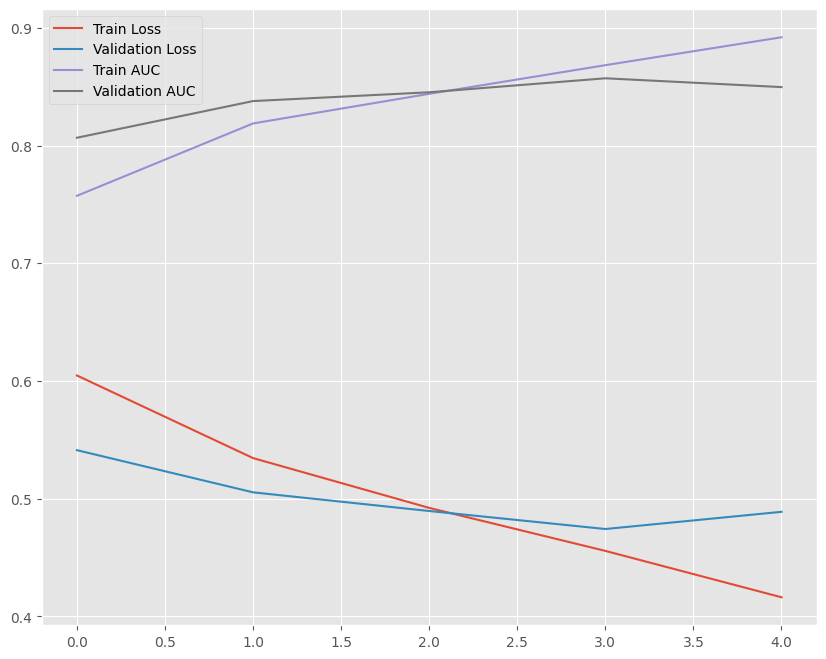

Validation AUC: 0.8557


In [50]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC 
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()

# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)

val_auc_index = model.metrics_names.index('auc')
auc_score_baseline2 = val_metrics[val_auc_index]

print(f"Validation AUC: {auc_score_baseline2:.4f}")

In [51]:
import numpy as np

def add_noise_to_weights(weights, noise_std=0.01):
    """Adds Gaussian noise to a dictionary of weights."""
    noisy_weights = {}
    for key, weight in weights.items():
        # Generating Gaussian noise with the same shape as the weight
        noise = np.random.normal(loc=0.0, scale=noise_std, size=weight.shape)
        # Adding the noise to the weight
        noisy_weight = weight + noise
        noisy_weights[key] = noisy_weight
    return noisy_weights

# Extract the model's weights into a dictionary
model_weights_dict_2 = {v.name: v.numpy() for v in model.trainable_variables}

# Add noise to the model's weights
noisy_model_weights_dict_2 = add_noise_to_weights(model_weights_dict_2, noise_std=0.01)

# Now, noisy_model_weights_dict contains the weights with added Gaussian noise

In [52]:
node_2 = sy.orchestra.launch(name="test-domain-2", port="auto", dev_mode=True, reset=True)

Staging Protocol Changes...
Starting test-domain-2 server on 0.0.0.0:56958


kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/alex


Waiting for server to start...

INFO:     Started server process [2521]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:56958 (Press CTRL+C to quit)


.
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/b626124c319343c882a448dac2d6953d.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=0 image_uid=e87282d0295048338da36dbba8128222 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
INFO:     127.0.0.1:53317 - "GET /api/v2/metadata HTTP/1.1" 200 OK
 Done.


Login to the Domain

In [53]:
domain_client_2 = node_2.login(email="info@openmined.org", password="changethis")

INFO:     127.0.0.1:53319 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:53319 - "GET /api/v2/metadata HTTP/1.1" 200 OK
Logged into <test-domain-2: High-side Domain> as GUEST
INFO:     127.0.0.1:53319 - "POST /api/v2/login HTTP/1.1" 200 OK
INFO:     127.0.0.1:53319 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:53322 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Logged into <test-domain-2: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

Initialize Model Weights

In [54]:
# Convert the trained model parameters to a Syft ActionObject
model_weights_obj = sy.ActionObject.from_obj(noisy_model_weights_dict_2)

# Check the object type and attributes
print(type(model_weights_obj.syft_action_data), model_weights_obj.id)


<class 'dict'> 60dd481cece142dead1773ccb2497f0d


In [55]:
# Set the model weights ActionObject in the domain
weight_domain_obj = domain_client_2.api.services.action.set(model_weights_obj)

# Check the domain object attributes
print(weight_domain_obj.id)


INFO:     127.0.0.1:53324 - "POST /api/v2/api_call HTTP/1.1" 200 OK
60dd481cece142dead1773ccb2497f0d


Convert Model Weights to Syft ActionObject:

Define a Weights Access function

In [56]:
@sy.syft_function(
    input_policy=sy.ExactMatch(weights=weight_domain_obj.id),
    output_policy=sy.SingleExecutionExactOutput(),
)
def fetch_weights(weights):
    # Simply return the weights; no computation needed
    return weights


INFO:     127.0.0.1:53327 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53331 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53319 - "GET /api/v2/metadata HTTP/1.1" 200 OK


SyftSuccess: Syft function 'fetch_weights' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Access Weights

In [57]:
weights_pointer = fetch_weights(weights=weight_domain_obj)
weights_local_2 = weights_pointer.get()

SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/01078a502fa543d7a102695d38eec650.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=8f3154e85ddc4642872e7a7bc7d32f50 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_7046: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:53343 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53345 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_7046
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieve and Verify the Output

Request and Approve Code Execution

In [58]:
request = domain_client_2.code.request_code_execution(fetch_weights)
request

INFO:     127.0.0.1:53358 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53319 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK
INFO:     127.0.0.1:53360 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53362 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53364 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53366 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53368 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53370 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53372 - "POST /api/v2/api_call HTTP/1.1" 200 OK


syft.service.request.request.Request

In [59]:
request.approve()

INFO:     127.0.0.1:53319 - "GET /api/v2/metadata HTTP/1.1" 200 OK
INFO:     127.0.0.1:53374 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53376 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53378 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53380 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53382 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53384 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53386 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain test-domain-2
INFO:     127.0.0.1:53389 - "POST /api/v2/api_call HTTP/1.1" 200 OK


SyftSuccess: Request dbce532651ad40f1975b894f97fe84ac changes applied

In [60]:
domain_client_2._api = None
_ = domain_client_2.api

INFO:     127.0.0.1:53319 - "GET /api/v2/api?verify_key=0dfade1de62080fb5e584e38a1b82ca623859caaefd6f13ae821a4e5172df446&communication_protocol=3 HTTP/1.1" 200 OK


Fetching the pointer and the actual weights

In [61]:
# Fetch the weights pointer from the domain
weights_ptr = fetch_weights(weights=weight_domain_obj)

# Retrieve the actual weights from the pointer
weights_local_2 = weights_ptr.get()


SyftInfo: Creating a node with n_consumers=2 (the default value)
Staging Protocol Changes...
SQLite Store Path:
!open file:///var/folders/78/1q4j7nsx4sg2djyc6d_1xq680000gn/T/db4b45870fc84d6b85f2e67b4d38bc97.sqlite

Creating default worker image with tag='local-dev'
Building default worker image with tag=local-dev
Setting up worker poolname=default-pool workers=2 image_uid=83d3058dac8349e69cc290387b056ee3 in_memory=True
Created default worker pool.
Data Migrated to latest version !!!
Logged into <ephemeral_node_fetch_weights_6580: High side Domain> as <info@openmined.org>


SyftWarning: You are using a default password. Please change the password using `[your_client].me.set_password([new_password])`.

INFO:     127.0.0.1:53426 - "POST /api/v2/api_call HTTP/1.1" 200 OK
INFO:     127.0.0.1:53428 - "POST /api/v2/api_call HTTP/1.1" 200 OK
Approving request for domain ephemeral_node_fetch_weights_6580
SyftInfo: Landing the ephmeral node...
SyftInfo: Node Landed!


Retrieving the Computation Result

Cleanup and Land the Node

In [62]:
if node_2.node_type.value == "python":
    node_2.land()

## Data Scientist

In [63]:
weights1 = weights_local
weights2 = weights_local_2

In [64]:
import jax.numpy as jnp

def combine_weights(weights1, weights2):
    """Combines two sets of weights by averaging."""
    global_weights = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights1.keys()) == set(weights2.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights1:
        layer_weights1 = weights1[key]
        layer_weights2 = weights2[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights1.shape == layer_weights2.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights[key] = (layer_weights1 + layer_weights2) / 2
    
    return global_weights


In [65]:
global_weights = combine_weights(weights1, weights_local_2)

# Data Owner 1 with Global Model Weights 

In [66]:
import jax.numpy as jnp

def combine_weights(weights1, global_weights, alpha=0.5): #alpha to determine the mix between global and local weights
    """Combines two sets of weights by averaging."""
    global_weights_mix_1 = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights1.keys()) == set(global_weights.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights1:
        layer_weights1 = weights1[key]
        layer_global_weights = global_weights[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights1.shape == layer_global_weights.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights_mix_1[key] = (alpha * layer_weights1 + (1- alpha) * layer_global_weights)
    
    return global_weights_mix_1


In [67]:
global_weights_mix_1 = combine_weights(weights_local, global_weights)

In [68]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df1)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df1[dense_cols].values, tf.float32),
        tf.cast(df1[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df1['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [69]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

class DLRM(tf.keras.Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot, arch_top, self_interaction):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

# Initialize the model
model = DLRM(
    embedding_sizes=embedding_sizes,
    embedding_dim=embedding_dim,
    arch_bot=arch_bot,
    arch_top=arch_top,
    self_interaction=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]
)

# Generate dummy input to build the model
dummy_input_dense = tf.random.uniform((1, len(dense_cols)), dtype=tf.float32)
dummy_input_cat = tf.random.uniform((1, len(cat_cols)), maxval=2, dtype=tf.int32)
model([dummy_input_dense, dummy_input_cat])  # This builds the model's layers

# Set the pre-trained weights
for layer in model.layers:
    if hasattr(layer, 'layers'):  # For nested layers
        for sub_layer in layer.layers:
            if sub_layer.name in global_weights_mix_1:
                sub_layer.set_weights(global_weights_mix_1[sub_layer.name])
    else:
        if layer.name in global_weights_mix_1:
            layer.set_weights(global_weights_mix_1[layer.name])


In [70]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 5s 6ms/step - loss: 0.6217 - accuracy: 0.7255 - auc: 0.7349 - val_loss: 0.5668 - val_accuracy: 0.7472 - val_auc: 0.7630
Epoch 2/5
427/427 [==============================] - 3s 7ms/step - loss: 0.5516 - accuracy: 0.7452 - auc: 0.7966 - val_loss: 0.5329 - val_accuracy: 0.7479 - val_auc: 0.8186
Epoch 3/5
427/427 [==============================] - 2s 6ms/step - loss: 0.5089 - accuracy: 0.7544 - auc: 0.8321 - val_loss: 0.5134 - val_accuracy: 0.7519 - val_auc: 0.8273
Epoch 4/5
427/427 [==============================] - 3s 6ms/step - loss: 0.4647 - accuracy: 0.7832 - auc: 0.8621 - val_loss: 0.4888 - val_accuracy: 0.7713 - val_auc: 0.8469
Epoch 5/5
427/427 [==============================] - 3s 6ms/step - loss: 0.4173 - accuracy: 0.8130 - auc: 0.8914 - val_loss: 0.5024 - val_accuracy: 0.7728 - val_auc: 0.8441


In [71]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple                  16824  

In [72]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 0s 1ms/step - loss: 0.5530 - accuracy: 0.7456 - auc: 0.8136
Loss: 0.553041934967041, Accuracy: 0.7455810904502869, AUC: 0.8135968446731567


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.621730,0.725507,0.734905,0.566755,0.747160,0.762963
1,0.551572,0.745182,0.796561,0.532885,0.747893,0.818612
2,0.508863,0.754378,0.832095,0.513441,0.751924,0.827275
3,0.464739,0.783194,0.862122,0.488839,0.771345,0.846925
4,0.417325,0.813036,0.891387,0.502398,0.772811,0.844125


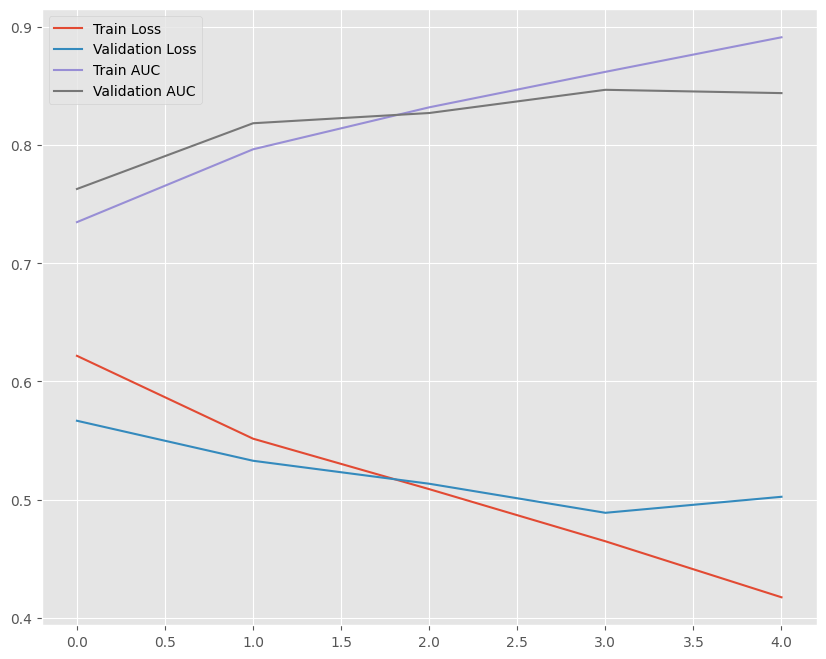

In [73]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [74]:
# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")

Validation AUC: 0.8434


In [75]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline1 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 99.78%


# Data Owner 2 with Global Model Weights 

In [76]:
import jax.numpy as jnp

def combine_weights(weights2, global_weights, alpha=0.5): #alpha to determine the mix between global and local weights
    """Combines two sets of weights by averaging."""
    global_weights_mix_2 = {}
    
    # Ensure the keys in both weight sets are identical
    assert set(weights2.keys()) == set(global_weights.keys()), "Weight sets have different structures"
    
    # Iterate through each layer's weights
    for key in weights2:
        layer_weights2 = weights2[key]
        layer_global_weights = global_weights[key]
        
        # Ensure each layer's weights have identical shapes
        assert layer_weights2.shape == layer_global_weights.shape, f"Layer {key} has different shapes"
        
        # Average the weights
        global_weights_mix_2[key] = (alpha * layer_weights2 + (1- alpha) * layer_global_weights)
    
    return global_weights_mix_2


In [77]:
global_weights_mix_2 = combine_weights(weights2, global_weights)

In [78]:
tf.keras.backend.clear_session() #clears keras session to have the same mapping for DO1 and DO2 dictionaries

TRAIN_SPLIT = 0.8
VALIDATION_SPLIT = 0.2

# Dataset size
dataset_size = len(df2)
train_size = int(dataset_size * TRAIN_SPLIT)
test_size = dataset_size - train_size
validation_size = int(test_size * VALIDATION_SPLIT)

# Creating the dataset
ds = tf.data.Dataset.zip((
    tf.data.Dataset.from_tensor_slices((
        tf.cast(df2[dense_cols].values, tf.float32),
        tf.cast(df2[cat_cols].values, tf.int32),
    )),
    tf.data.Dataset.from_tensor_slices(tf.cast(to_categorical(df2['label'].values, num_classes=2), tf.float32))
)).shuffle(buffer_size=2048)

# Splitting the dataset
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(validation_size)
ds_test = ds_test.skip(validation_size)

In [79]:
embedding_sizes = [emb_count for emb_count in emb_counts]

# Model architecture parameters
embedding_dim = 2
arch_bot = [8, 2]  # Architecture for the bottom MLP (processing dense features)
arch_top = [128, 64, 2]  # Architecture for the top MLP (combining embeddings and processed dense features)

class DLRM(tf.keras.Model):
    def __init__(self, embedding_sizes, embedding_dim, arch_bot, arch_top, self_interaction):
        super(DLRM, self).__init__()
        self.emb = [tf.keras.layers.Embedding(size, embedding_dim) for size in embedding_sizes]
        self.bot_nn = MLP(arch_bot, out_activation='relu')
        self.top_nn = MLP(arch_top, out_activation='sigmoid')
        self.interaction_op = SecondOrderFeatureInteraction(self_interaction)

    def call(self, inputs):
        input_dense, input_cat = inputs
        emb_x = [E(x) for E, x in zip(self.emb, tf.unstack(input_cat, axis=1))]
        dense_x = self.bot_nn(input_dense)

        Z = self.interaction_op(emb_x + [dense_x])
        z = tf.concat([dense_x, Z], axis=1)
        p = self.top_nn(z)

        return p

# Initialize the model
model = DLRM(
    embedding_sizes=embedding_sizes,
    embedding_dim=embedding_dim,
    arch_bot=arch_bot,
    arch_top=arch_top,
    self_interaction=False
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy', AUC(name='auc')]
)

# Generate dummy input to build the model
dummy_input_dense = tf.random.uniform((1, len(dense_cols)), dtype=tf.float32)
dummy_input_cat = tf.random.uniform((1, len(cat_cols)), maxval=2, dtype=tf.int32)
model([dummy_input_dense, dummy_input_cat])  # This builds the model's layers

# Set the pre-trained weights
for layer in model.layers:
    if hasattr(layer, 'layers'):  # For nested layers
        for sub_layer in layer.layers:
            if sub_layer.name in global_weights_mix_2:
                sub_layer.set_weights(global_weights_mix_2[sub_layer.name])
    else:
        if layer.name in global_weights_mix_2:
            layer.set_weights(global_weights_mix_2[layer.name])


In [80]:
BATCH_SIZE = 128

history =model.fit(
    ds_train.batch(BATCH_SIZE),
    validation_data=ds_valid.batch(BATCH_SIZE),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
    ],
    epochs=5,
    verbose=1,
)


Epoch 1/5
427/427 [==============================] - 3s 5ms/step - loss: 0.6026 - accuracy: 0.7495 - auc: 0.7477 - val_loss: 0.5452 - val_accuracy: 0.7596 - val_auc: 0.7979
Epoch 2/5
427/427 [==============================] - 2s 5ms/step - loss: 0.5369 - accuracy: 0.7496 - auc: 0.8165 - val_loss: 0.5190 - val_accuracy: 0.7585 - val_auc: 0.8233
Epoch 3/5
427/427 [==============================] - 2s 5ms/step - loss: 0.4934 - accuracy: 0.7648 - auc: 0.8428 - val_loss: 0.4991 - val_accuracy: 0.7647 - val_auc: 0.8368
Epoch 4/5
427/427 [==============================] - 2s 5ms/step - loss: 0.4575 - accuracy: 0.7866 - auc: 0.8665 - val_loss: 0.4759 - val_accuracy: 0.7823 - val_auc: 0.8550
Epoch 5/5
427/427 [==============================] - 2s 5ms/step - loss: 0.4200 - accuracy: 0.8108 - auc: 0.8894 - val_loss: 0.4961 - val_accuracy: 0.7699 - val_auc: 0.8449


In [81]:
model.summary()

Model: "dlrm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1204      
                                                                 
 embedding_1 (Embedding)     multiple                  1022      
                                                                 
 embedding_2 (Embedding)     multiple                  114322    
                                                                 
 embedding_3 (Embedding)     multiple                  59116     
                                                                 
 embedding_4 (Embedding)     multiple                  330       
                                                                 
 embedding_5 (Embedding)     multiple                  26        
                                                                 
 embedding_6 (Embedding)     multiple                  16824  

In [82]:
results = model.evaluate(ds_test.batch(BATCH_SIZE))
print(f'Loss: {results[0]}, Accuracy: {results[1]}, AUC: {results[2]}')

86/86 [==============================] - 0s 2ms/step - loss: 0.5225 - accuracy: 0.7579 - auc: 0.8291
Loss: 0.5224699974060059, Accuracy: 0.7579448819160461, AUC: 0.8290612697601318


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
0,0.602616,0.749510,0.747661,0.545235,0.759619,0.797912
1,0.536906,0.749638,0.816457,0.519006,0.758520,0.823305
2,0.493391,0.764769,0.842838,0.499105,0.764749,0.836765
3,0.457514,0.786605,0.866485,0.475862,0.782338,0.854952
4,0.420041,0.810823,0.889392,0.496075,0.769879,0.844895


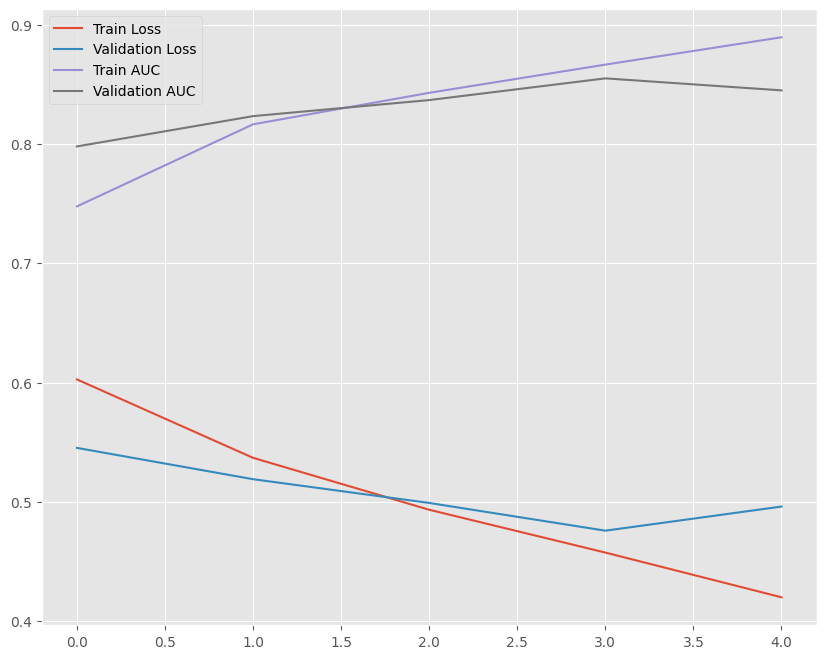

In [83]:
loss = pd.DataFrame.from_dict(history.history)
display(loss.head())

plt.figure(figsize=(10,8))
plt.plot(loss['loss'], label='Train Loss')
plt.plot(loss['val_loss'], label='Validation Loss')

# Plot AUC
plt.plot(loss['auc'], label='Train AUC')
plt.plot(loss['val_auc'], label='Validation AUC')

plt.legend()
plt.show()


In [84]:
# Evaluate the model on the validation dataset
val_metrics = model.evaluate(ds_valid.batch(BATCH_SIZE), verbose=0)
val_auc_index = model.metrics_names.index('auc')
val_auc = val_metrics[val_auc_index]

print(f"Validation AUC: {val_auc:.4f}")


Validation AUC: 0.8541


In [85]:
rela_impr = ((val_auc - 0.5) / (auc_score_baseline2 - 0.5)) * 100
print(f"Relative Improvement (RelaImpr): {rela_impr:.2f}%")

Relative Improvement (RelaImpr): 99.56%
